## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_classes = 10

In [ ]:
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
5


In [ ]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

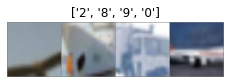

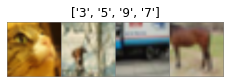

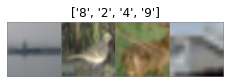

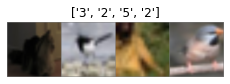

In [ ]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [ ]:
from torchvision import models

In [ ]:
vgg = models.vgg16_bn()

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.40
Iteration: 100/3125, Loss: 2.33
Iteration: 200/3125, Loss: 2.26
Iteration: 300/3125, Loss: 1.84
Iteration: 400/3125, Loss: 1.92
Iteration: 500/3125, Loss: 2.22
Iteration: 600/3125, Loss: 2.22
Iteration: 700/3125, Loss: 2.02
Iteration: 800/3125, Loss: 2.22
Iteration: 900/3125, Loss: 1.96
Iteration: 1000/3125, Loss: 1.82
Iteration: 1100/3125, Loss: 2.03
Iteration: 1200/3125, Loss: 2.04
Iteration: 1300/3125, Loss: 1.89
Iteration: 1400/3125, Loss: 2.18
Iteration: 1500/3125, Loss: 2.16
Iteration: 1600/3125, Loss: 2.22
Iteration: 1700/3125, Loss: 1.98
Iteration: 1800/3125, Loss: 2.37
Iteration: 1900/3125, Loss: 1.76
Iteration: 2000/3125, Loss: 2.00
Iteration: 2100/3125, Loss: 2.04
Iteration: 2200/3125, Loss: 1.71
Iteration: 2300/3125, Loss: 2.04
Iteration: 2400/3125, Loss: 1.72
Iteration: 2500/3125, Loss: 1.93
Iteration: 2600/3125, Loss: 1.58
Iteration: 2700/3125, Loss: 1.59
Iteration: 2800/3125, Loss: 2.21
Iteration: 2900/3125, Loss: 1.89
Iteration: 3000/3125, 

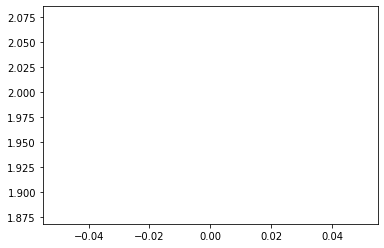

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

### Freeze layers of Convolutional Operations

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.48
Iteration: 100/3125, Loss: 1.96
Iteration: 200/3125, Loss: 1.97
Iteration: 300/3125, Loss: 2.98
Iteration: 400/3125, Loss: 2.16
Iteration: 500/3125, Loss: 2.51
Iteration: 600/3125, Loss: 1.74
Iteration: 700/3125, Loss: 1.78
Iteration: 800/3125, Loss: 1.95
Iteration: 900/3125, Loss: 1.11
Iteration: 1000/3125, Loss: 1.86
Iteration: 1100/3125, Loss: 2.07
Iteration: 1200/3125, Loss: 1.81
Iteration: 1300/3125, Loss: 2.18
Iteration: 1400/3125, Loss: 2.19
Iteration: 1500/3125, Loss: 2.07
Iteration: 1600/3125, Loss: 2.04
Iteration: 1700/3125, Loss: 3.02
Iteration: 1800/3125, Loss: 1.48
Iteration: 1900/3125, Loss: 2.11
Iteration: 2000/3125, Loss: 1.65
Iteration: 2100/3125, Loss: 1.98
Iteration: 2200/3125, Loss: 1.96
Iteration: 2300/3125, Loss: 2.19
Iteration: 2400/3125, Loss: 1.36
Iteration: 2500/3125, Loss: 2.22
Iteration: 2600/3125, Loss: 2.53
Iteration: 2700/3125, Loss: 1.43
Iteration: 2800/3125, Loss: 3.34
Iteration: 2900/3125, Loss: 1.93
Iteration: 3000/3125, 

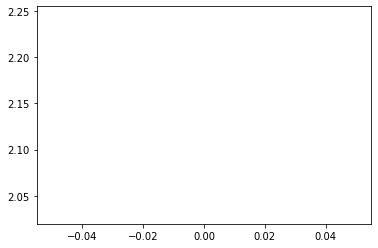

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

### With model copies

In [ ]:
import copy

In [ ]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 3.38
Iteration: 0/3125, Loss: 3.38
Min loss 1.89
Min loss 1.69
Min loss 1.60
Min loss 1.37
Min loss 0.87
Min loss 0.80
Iteration: 100/3125, Loss: 1.14
Iteration: 200/3125, Loss: 2.07
Iteration: 300/3125, Loss: 1.17
Iteration: 400/3125, Loss: 2.94
Iteration: 500/3125, Loss: 1.14
Iteration: 600/3125, Loss: 2.88
Iteration: 700/3125, Loss: 1.92
Min loss 0.55
Iteration: 800/3125, Loss: 1.44
Iteration: 900/3125, Loss: 2.62
Iteration: 1000/3125, Loss: 2.45
Iteration: 1100/3125, Loss: 1.61
Min loss 0.48
Iteration: 1200/3125, Loss: 2.38
Iteration: 1300/3125, Loss: 2.15
Iteration: 1400/3125, Loss: 2.60
Iteration: 1500/3125, Loss: 1.21
Iteration: 1600/3125, Loss: 2.31
Iteration: 1700/3125, Loss: 2.51
Iteration: 1800/3125, Loss: 3.70
Iteration: 1900/3125, Loss: 2.21
Iteration: 2000/3125, Loss: 1.59
Iteration: 2100/3125, Loss: 1.56
Iteration: 2200/3125, Loss: 2.03
Min loss 0.34
Iteration: 2300/3125, Loss: 2.44
Iteration: 2400/3125, Loss: 2.16
Iteration: 2500/3125, Loss: 1.49
Iteration: 260

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [ ]:
resnet = models.resnet18(pretrained=True)

In [ ]:
print(resnet)

In [35]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.74
Iteration: 0/3125, Loss: 2.74
Min loss 2.30
Min loss 2.09
Min loss 2.06
Min loss 1.92
Min loss 1.91
Min loss 1.80
Min loss 1.76
Min loss 1.67
Min loss 1.57
Iteration: 100/3125, Loss: 1.83
Min loss 1.56
Min loss 1.45
Min loss 1.27
Iteration: 200/3125, Loss: 1.64
Min loss 1.23
Min loss 1.14
Min loss 1.13
Iteration: 300/3125, Loss: 1.38
Min loss 1.13
Min loss 1.05
Iteration: 400/3125, Loss: 1.46
Min loss 1.04
Min loss 1.01
Iteration: 500/3125, Loss: 1.24
Min loss 0.98
Min loss 0.89
Iteration: 600/3125, Loss: 1.62
Min loss 0.84
Iteration: 700/3125, Loss: 0.98
Iteration: 800/3125, Loss: 1.45
Iteration: 900/3125, Loss: 1.61
Min loss 0.84
Min loss 0.83
Iteration: 1000/3125, Loss: 1.13
Min loss 0.81
Min loss 0.73
Min loss 0.67
Iteration: 1100/3125, Loss: 1.63
Iteration: 1200/3125, Loss: 1.42
Iteration: 1300/3125, Loss: 1.39
Min loss 0.67
Iteration: 1400/3125, Loss: 1.03
Iteration: 1500/3125, Loss: 1.41
Iteration: 1600/3125, Loss: 1.00
Iteration: 1700/3125, Loss: 1.21
Iteration: 1

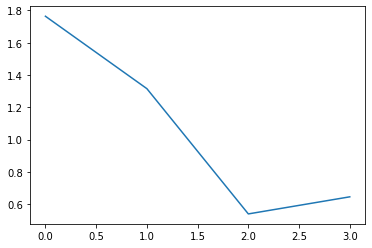

In [39]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
print(inception)

In [ ]:
for param in inception.parameters():
    param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [47]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [49]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [51]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [52]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 2.90
Iteration: 0/3125, Loss: 2.90
Min loss 2.79
Min loss 2.78
Min loss 2.70
Min loss 2.68
Min loss 2.59
Min loss 2.52
Iteration: 100/3125, Loss: 2.73
Min loss 2.39
Min loss 2.36
Iteration: 200/3125, Loss: 2.48
Min loss 2.28
Min loss 2.24
Min loss 2.16
Min loss 2.09
Min loss 1.97
Iteration: 300/3125, Loss: 2.39
Min loss 1.96
Iteration: 400/3125, Loss: 2.55
Min loss 1.94
Min loss 1.92
Min loss 1.78
Iteration: 500/3125, Loss: 1.85
Min loss 1.69
Min loss 1.52
Iteration: 600/3125, Loss: 2.24
Iteration: 700/3125, Loss: 2.02
Iteration: 800/3125, Loss: 2.01
Iteration: 900/3125, Loss: 2.20
Iteration: 1000/3125, Loss: 2.11
Min loss 1.30
Iteration: 1100/3125, Loss: 2.03
Min loss 1.29
Iteration: 1200/3125, Loss: 2.26
Iteration: 1300/3125, Loss: 2.03
Min loss 1.23
Iteration: 1400/3125, Loss: 2.02
Min loss 1.08
Iteration: 1500/3125, Loss: 2.28
Iteration: 1600/3125, Loss: 2.27
Iteration: 1700/3125, Loss: 2.48
Iteration: 1800/3125, Loss: 1.63
Iteration: 1900/3125, Loss: 2.59
Iteration: 2000/

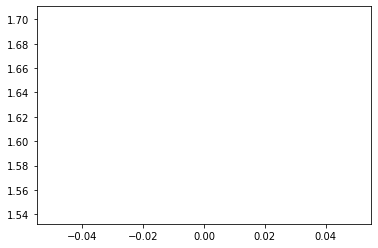

In [53]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))